In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier

#dataset
data = pd.read_csv("cleaned_data_15_4_2024.csv")

# Define features and target variables
feature_columns = ['age', 'Violence and Abuse', 'Accidents and Medical', 'Theft and Fraud', 'Loss and Death', 'gender_Female', 'gender_Male', 'gender_Other']
targets = ['Personal Support', 'Professional and Specialized Support','Community and Workplace Support', 'Legal and Official Support', 'No Help Sought']

# Split data based on the survey year
train_data = data[data['year_of_survey'] <= 2021]
validation_data = data[data['year_of_survey'] == 2022]
test_data = data[data['year_of_survey'] == 2023]

# Extract features and targets for each dataset
X_train, y_train = train_data[feature_columns], train_data[targets]
X_val, y_val = validation_data[feature_columns], validation_data[targets]
X_test, y_test = test_data[feature_columns], test_data[targets]

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hyperparameters to tune for XGBoost
param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__n_estimators': [50, 100, 200],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2]
}

# Scoring for GridSearchCV
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}  # adjust according to your needs

# Create an empty list to hold all individual classifiers
classifiers = []

# Apply SMOTEENN and GridSearchCV for each label individually
for i, target in enumerate(targets):
    smote_enn = SMOTEENN(smote=SMOTE(random_state=42), enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train[target])
    
    # Define the XGBoost model pipeline
    pipeline = Pipeline([
        ('xgbclassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
    
    # Grid search to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='AUC')
    grid_search.fit(X_resampled, y_resampled)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Append the best model to the list of classifiers
    classifiers.append(best_model)

# Evaluate each model on the validation and test set, collect predictions
y_val_pred = np.column_stack([model.predict(X_val_scaled) for model in classifiers])
y_test_pred = np.column_stack([model.predict(X_test_scaled) for model in classifiers])
# Predictions for the training set
y_train_pred = np.column_stack([model.predict(X_train_scaled) for model in classifiers])

# Calculate metrics for the training set
precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')
roc_auc_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred[:, i]) for i in range(y_train.shape[1])])

# Display classification report for the training set
print(f'Training Precision: {precision_train}')
print(f'Training Recall: {recall_train}')
print(f'Training F1-score: {f1_train}')
print(f'Training ROC-AUC score: {roc_auc_train}')
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred, target_names=targets))
# Calculate metrics
precision_val = precision_score(y_val, y_val_pred, average='macro')
recall_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')
roc_auc_val = np.mean([roc_auc_score(y_val.iloc[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])])

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
roc_auc_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred[:, i]) for i in range(y_test.shape[1])])

# Display classification report for validation set
print(f'Validation Precision: {precision_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1-score: {f1_val}')
print(f'Validation ROC-AUC score: {roc_auc_val}')
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=targets))

# Display classification report for test set
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1-score: {f1_test}')
print(f'Test ROC-AUC score: {roc_auc_test}')
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=targets))


Training Precision: 0.49188651443113934
Training Recall: 0.6268989303221495
Training F1-score: 0.5349726441326943
Training ROC-AUC score: 0.68179693234581

Training Classification Report:
                                       precision    recall  f1-score   support

                    Personal Support       0.91      0.81      0.86      7215
Professional and Specialized Support       0.50      0.67      0.57      1825
     Community and Workplace Support       0.48      0.51      0.50      2427
          Legal and Official Support       0.41      0.70      0.52      1323
                      No Help Sought       0.16      0.44      0.23       471

                           micro avg       0.63      0.71      0.67     13261
                           macro avg       0.49      0.63      0.53     13261
                        weighted avg       0.70      0.71      0.70     13261
                         samples avg       0.67      0.73      0.66     13261

Validation Precision: 0.4528

C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import pandas as pd

metrics_data = {
    'Data Split': ['Train', 'Validation', 'Test'],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_train, f1_val, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_val, roc_auc_test]
}

results_df = pd.DataFrame(metrics_data)

print(results_df)
results_df.to_csv("XGBoost_evaluation_metrics.csv", index=False)

   Data Split  Precision    Recall  F1 Score   ROC-AUC
0       Train   0.491887  0.626899  0.534973  0.681797
1  Validation   0.452856  0.559770  0.486763  0.632655
2        Test   0.459064  0.560720  0.488310  0.639773


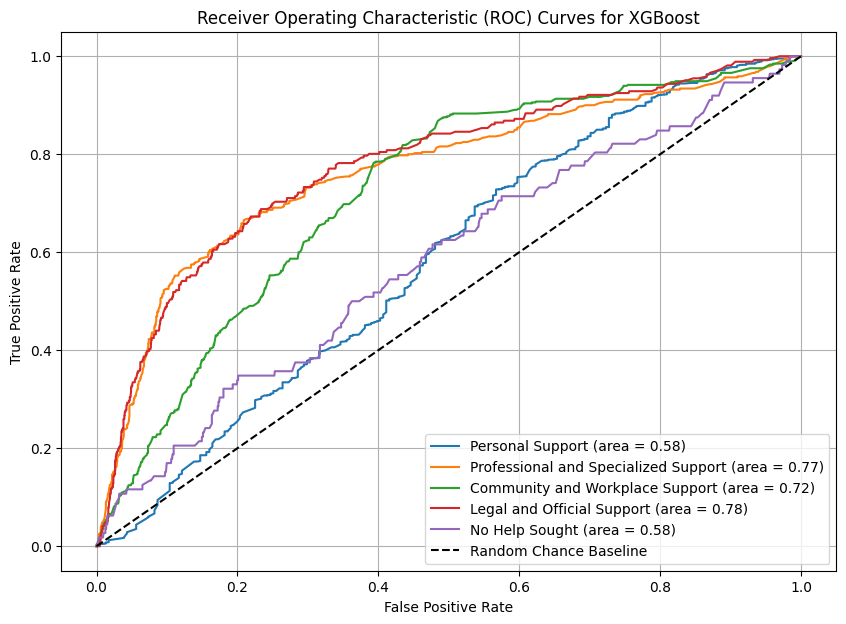

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
# Function to plot ROC curves for each target
def plot_multiclass_roc_auc(y_true, y_scores, targets, figsize=(10, 7)):
    plt.figure(figsize=figsize)

    for i, target in enumerate(targets):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{target} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for XGBoost')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


y_scores = np.column_stack([model.predict_proba(X_test_scaled)[:, 1] for model in classifiers])

y_true = y_test.to_numpy()

#Plot ROC-AUC curves
plot_multiclass_roc_auc(y_true, y_scores, targets)
